In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
produccion = pd.read_csv('drive/MyDrive/Ficheros/20190321_Produccion_Fotovoltaicas.csv')

instalacion = pd.read_csv('drive/MyDrive/Ficheros/20190321_Instalaciones_Fotovoltaicas.csv')

In [156]:
dataframe = produccion.merge(instalacion, on='cil')

dataframe.produccion_kWh = dataframe['produccion_kWh']/dataframe['potenciaPicoKw']

dataframe.drop(columns=['cil', 'consumo_kWh', 'numSerie', 'modelo', 'marca', 'lat',	'lng',	'potenciaNominalKw',	'potenciaPicoKw'],inplace=True )

dataframe.index = pd.to_datetime(dataframe.fecha)

In [157]:
dataframe = dataframe.groupby(by='instalacion_fk').resample('1M').sum()
dataframe.drop(columns='instalacion_fk',inplace=True)

In [158]:
dataframe.reset_index(inplace=True)

dataframe.sample(10)

,instalacion_fk,fecha,produccion_kWh
421,6,2013-02-28,47.952111
20,1,2012-09-30,115.774217
233,4,2013-12-31,79.494949
277,4,2017-08-31,131.385281
536,7,2014-06-30,82.548726
319,5,2012-11-30,67.182697
45,1,2014-10-31,96.932120
513,7,2012-07-31,60.127436
354,5,2015-10-31,89.920949
344,5,2014-12-31,70.597277


In [159]:
dataframe.index = dataframe.fecha
dataframe['mes'] = dataframe.fecha.dt.month

In [160]:
grafica = dataframe.loc['2016-01-01':'2016-12-31']

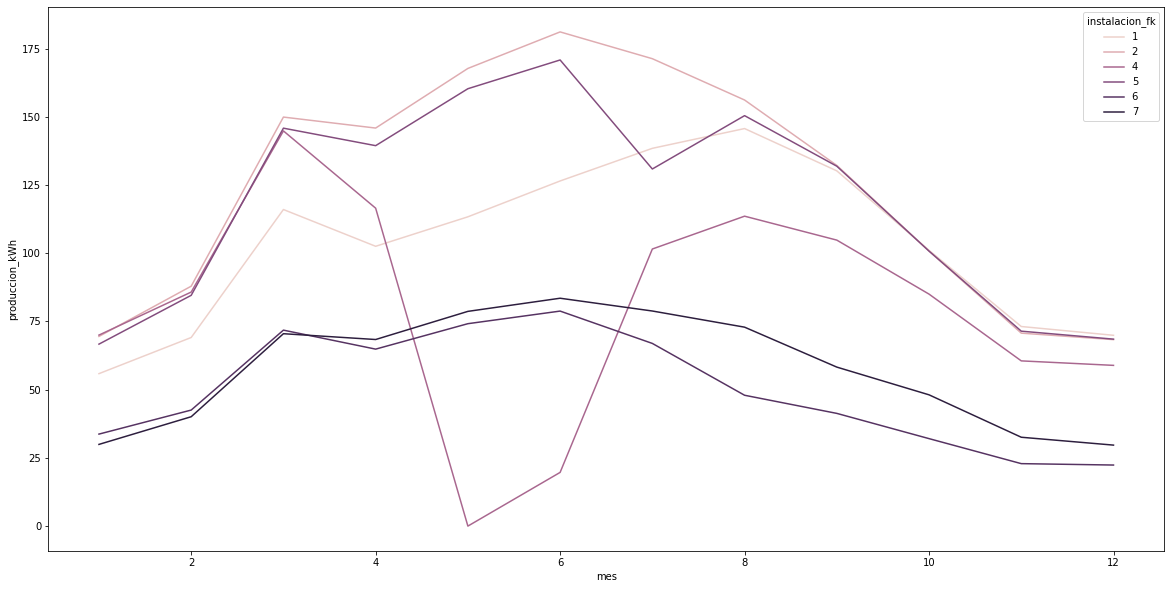

In [161]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=grafica, x ='mes', y='produccion_kWh',hue='instalacion_fk', ax=ax)

In [162]:
import typing
import pandas as pd

class SklearnWrapper:
    def __init__(self, transform: typing.Callable):
        self.transform = transform

    def __call__(self, df):
        transformed = self.transform.fit_transform(df.values)
        return pd.DataFrame(transformed, columns=df.columns, index=df.index)

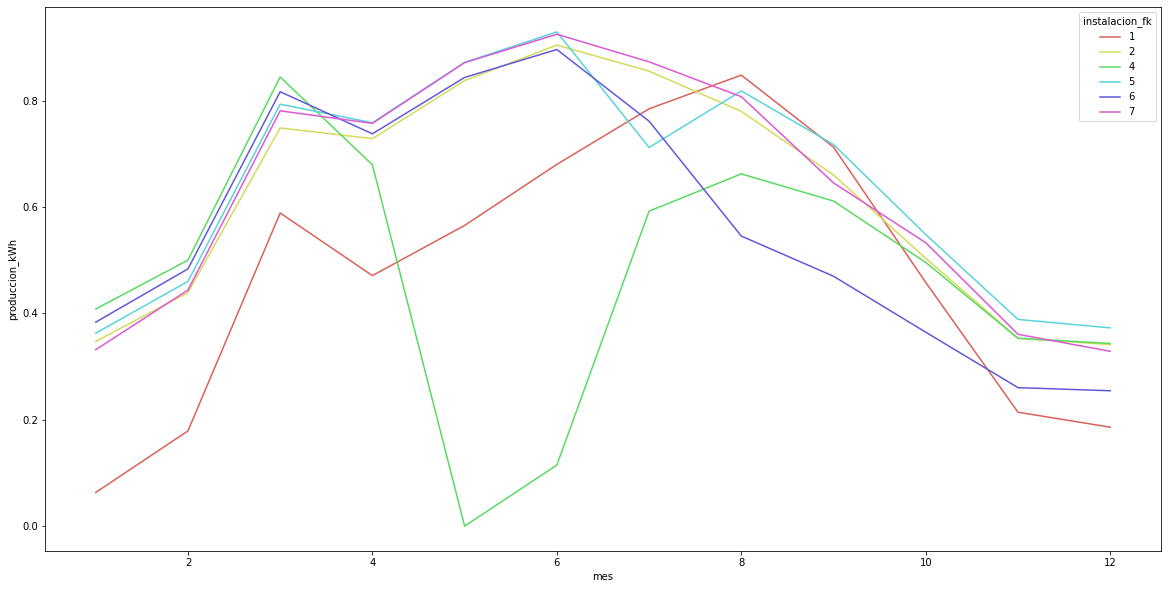

In [163]:

df = dataframe.drop(['fecha','mes'], axis=1)


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

df_rescaled = (
    df.groupby(["instalacion_fk"])
    .apply(SklearnWrapper(MinMaxScaler()))
    .drop("instalacion_fk", axis="columns")
)

df_rescaled['instalacion_fk'] = dataframe.instalacion_fk

df_rescaled['mes'] = df_rescaled.index.month

df_rescaled['fecha'] = df_rescaled.index

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=df_rescaled.loc['2016-01-01':'2016-12-31'], x ='mes', y='produccion_kWh',hue='instalacion_fk', ax=ax, palette=sns.color_palette("hls", 6))

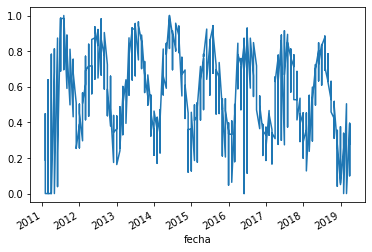

In [164]:
df_rescaled.produccion_kWh.plot()

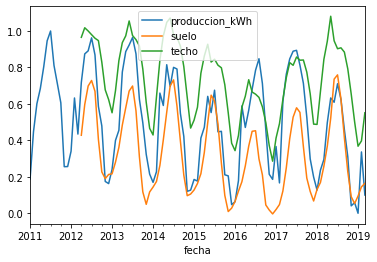

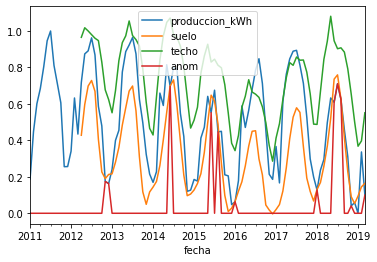

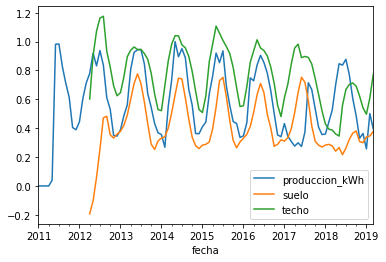

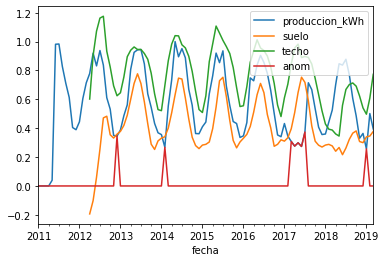

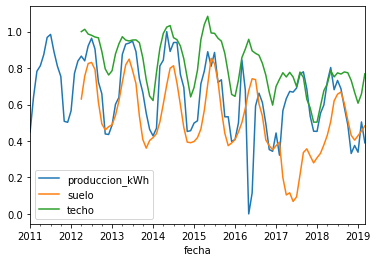

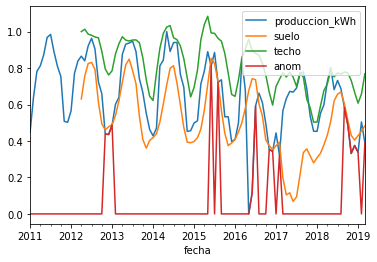

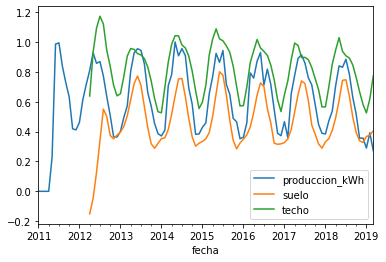

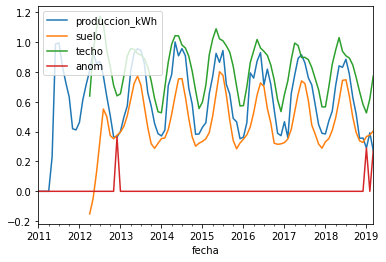

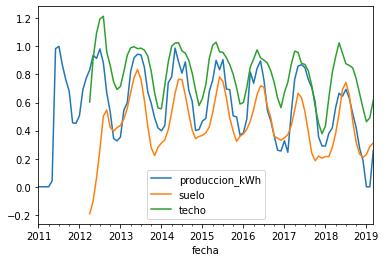

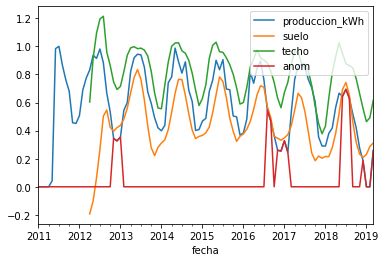

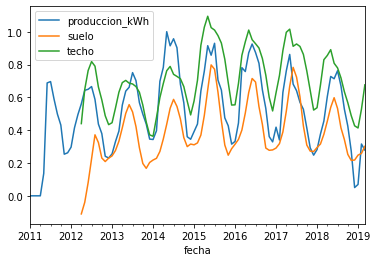

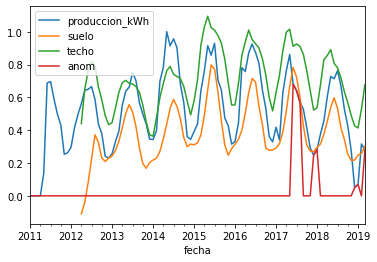

In [173]:
wind =15
sigma = 2

contador = 0
# df_rescaled.drop(columns='mes', inplace=True)

for nombre, df in df_rescaled.groupby(by='instalacion_fk'):
  
  df.index = df.fecha
  # indexDate = df[ df['produccion_kWh'] == 0 ].index
  # df.drop(indexDate, inplace=True)

  media = df['produccion_kWh'].rolling(window=5).mean().to_list()
  desviacion = df['produccion_kWh'].rolling(window=6).std().to_list()
  
  for _ in range(0,10):
    media.insert(0,np.NaN)
    media.pop(-1)
    desviacion.insert(0,np.NaN)
    desviacion.pop(-1)

  df['suelo'] = np.array(media) - np.array(desviacion)
  df['techo'] = np.array(media) + np.array(desviacion)

  # df["suelo"] = df['produccion_kWh'].rolling(window=wind).mean() - (sigma * df['produccion_kWh'].rolling(window=wind).std())
  # df["techo"] = df['produccion_kWh'].rolling(window=wind).mean() + (sigma * df['produccion_kWh'].rolling(window=wind).std())
  
  df.drop(columns=['mes','fecha','instalacion_fk']).plot()

  df["anom"] = df.apply( lambda row: row['produccion_kWh'] if (row['produccion_kWh']<=row["suelo"]) else 0 , axis=1)
  
  df.drop(columns=['mes','fecha','instalacion_fk']).plot()
  
  # for i in df.index:
  #  if df['anom'][i] != np.NaN:
  #    contador +=1
